In [40]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%autoreload 2
from classes.data_wraper import Dataset
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile, apply_mask

In [42]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [43]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, 'data')
else:
    data_dir = os.path.join(root_dir, 'data')

In [44]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [45]:
calibration_maps = [paths['FOVfiting2']]
dataset = Dataset(calibration_maps, save_maps=True)

Added data from c:\Users\f076048\Documents\Stage_CSL\data\mapsCeline_FOVfitting_2_pol-60.mat
New lenght: 297


In [46]:
dataset.preprocess_data()
dataset.crop_data(128)

In [47]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list
azimut = dataset.azimut_list

In [75]:
model = 'UNet'
if 'google.colab' in sys.modules:
    model_path = os.path.join(root_dir, model)
else:
    model_path = os.path.join(root_dir, 'models', model)
model_path_mae = model_path + '_mae'
unet_mae = UNet(model_path=model_path_mae)
model_path_mse = model_path + '_mse'
unet_mse = UNet(model_path=model_path_mse)

Loaded model from c:\Users\f076048\Documents\Stage_CSL\models\UNet_mae
Loaded model from c:\Users\f076048\Documents\Stage_CSL\models\UNet_mse


In [49]:
def get_center(map):
    max_value = np.max(map)
    max_index = np.where(map == max_value)
    return max_index[0][0], max_index[1][0]

1/1 [==============================] - 0s 143ms/step


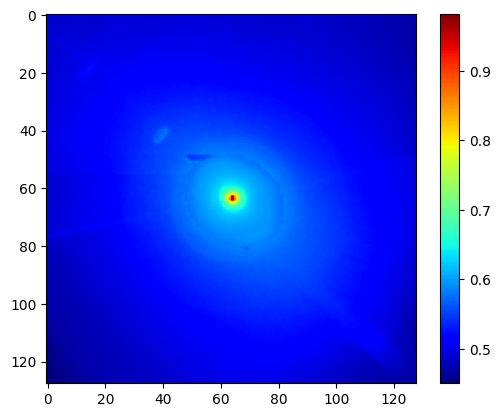

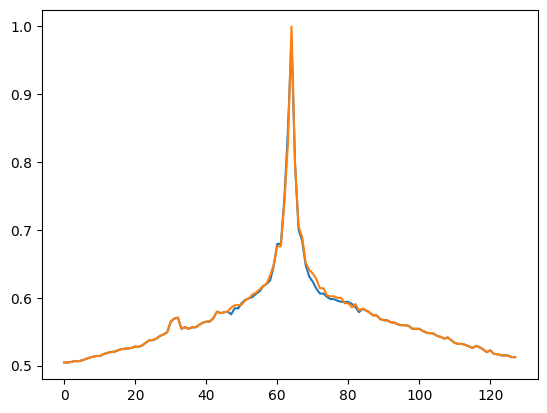

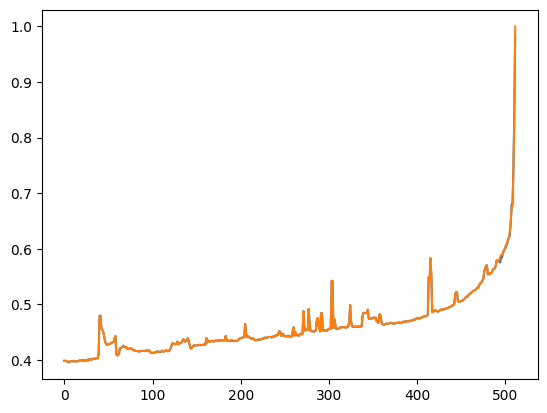

In [80]:
ind = random.randint(0, len(X)-1)
map3_orig = dataset.map3_list_sv[ind]
map1_orig = dataset.map1_list_sv[ind]
center = get_center(map1_orig)
crop_size = 128
box = (center[0]-crop_size//2, center[1]-crop_size//2, center[0]+crop_size//2, center[1]+crop_size//2)
box = np.clip(box, 0, 512)
# remove the cropped part of the map
map3_orig[box[0]:box[2], box[1]:box[3]] = 0

map3 = dataset.map3_list[ind]
mask3 = dataset.mask3_list[ind]
pred = (unet_mae.model.predict(X[ind:ind+1])[0, :, :, 0] + unet_mse.model.predict(X[ind:ind+1])[0, :, :, 0]) / 2
pred_fused = pred * mask3 + (map3 * (1 - mask3))
label = dataset.combined_list[ind]
plot_map(pred_fused)
plot_radial_profile([pred_fused, label], azimut[ind])
# replace the cropped part with the predicted map
map3_orig[box[0]:box[2], box[1]:box[3]] = pred_fused[0:(box[2]-box[0]), 0:(box[3]-box[1])]

label = dataset.combined_list_sv[ind]
plot_radial_profile([map3_orig, label], azimut[ind])

1/1 [==============================] - 0s 155ms/step


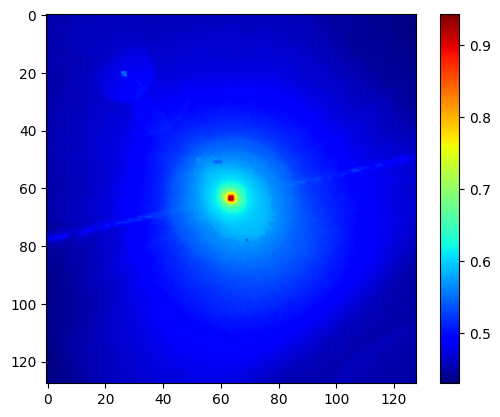

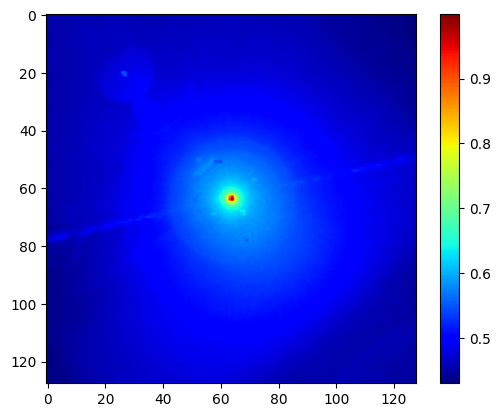

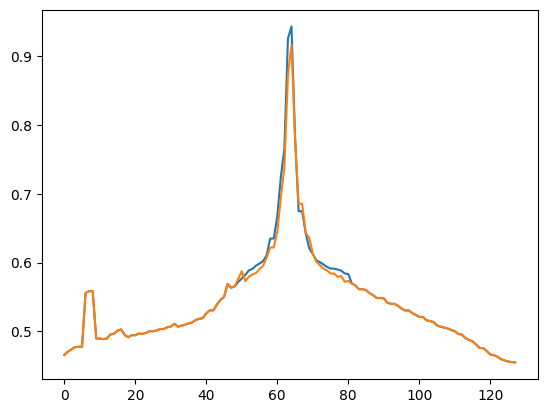

In [52]:
ind = random.randint(0, len(X) - 1)
map3 = X[ind, :, :, 2]
mask3 = dataset.mask3_list[ind]
label = y[ind, :, :]
pred = unet.model.predict(X[ind:ind+1])[0, :, :, 0]
pred_fused = np.add(np.multiply(pred, mask3), np.multiply(map3, (1 - mask3)))
plot_map(pred_fused)
plot_map(label)
